In [1]:
%matplotlib inline
import sys
sys.path.append('../src')
from params import params as P
import numpy as np
import patch_sampling
from parallel import ParallelBatchIterator
np.random.seed(1)
P.DATA_LEVEL=0

train_generator, validation_generator = patch_sampling.prepare_sampler()

Loaded configurations from (in order) ['../src/../config/default.ini', '../src/../config/notebook.ini']
OpenCV 2 NOT AVAILABLE, using skimage/scipy.ndimage instead
Loading validation masks


  0%|          | 0/63 [00:00<?, ?it/s]

Done in  6.05576992035
... is done
Loading train masks


100%|██████████| 63/63 [00:11<00:00,  5.25it/s]

Done in  12.0473709106
... is done


181.939
181.947


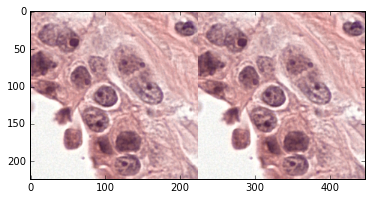

180.384
180.382


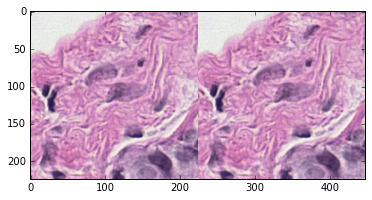

132.47
132.468


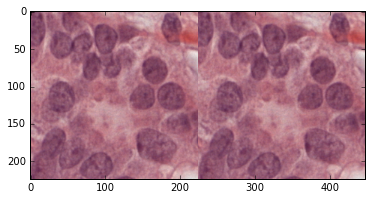

171.95
171.945


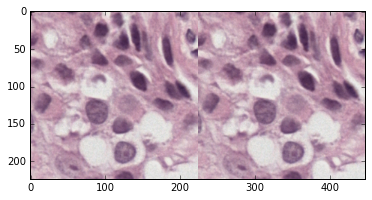

190.902
190.915


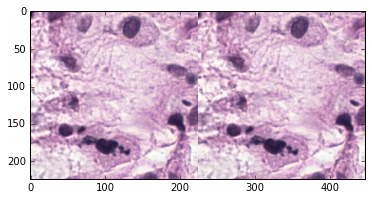

217.508
217.499


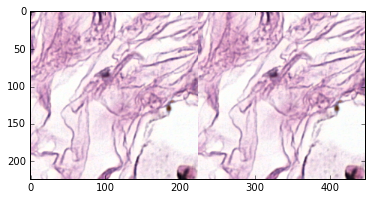

176.686
176.687


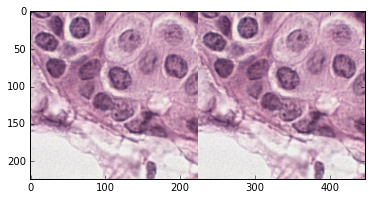

159.467
159.473


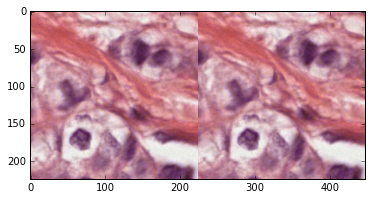

207.988
208.01


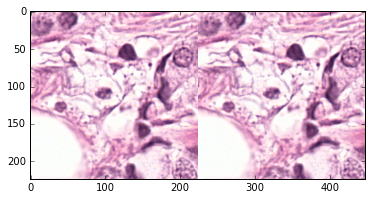

206.051
206.055


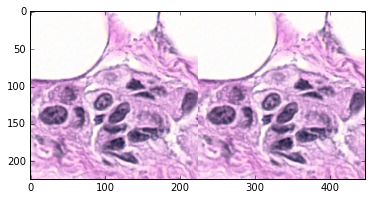

In [64]:
import util
X_train = [1]*10

X_val = [1]*1
val_gen = ParallelBatchIterator(validation_generator, X_val, ordered=False,
                                                batch_size=1,
                                                multiprocess=False,
                                                n_producers=2)

train_gen = ParallelBatchIterator(train_generator, X_train, ordered=False,
                                                batch_size=1,
                                                multiprocess=False,
                                                n_producers=2)
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)


for batch in train_gen:
    images, labels = batch
    images = util.unzero_center(images, P.MEAN_PIXEL)
    
    im = images[0]*255
    im = im.transpose(1,2,0)
    print np.mean(im)
    
    
    el_im = elastic_transform(im, 30, 20)
    print np.mean(el_im)

    
    plt.imshow(np.hstack((im/255, el_im/255)))
    plt.show()
    
    
